In [1]:
# libraries
import io
import os
import pyarrow.parquet as pq
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords

PATH = 'C:/Users/chris/CA684_ML_Assignment/data'
parquet_filenames_train = !ls {PATH}/parquet/train
tfrecords_filenames_train = !ls {PATH}/tfrecords/train

In [2]:
# set the path to your data directory
pq_path = 'C:/Users/chris/CA684_ML_Assignment/data/parquet/train'

# read all Parquet files in the directory into a single PyArrow table
table = pq.read_table(pq_path)

# convert the table to a Pandas DataFrame
df_train = table.to_pandas()

In [3]:
df_train.head

<bound method NDFrame.head of         product_id                                              title  \
0        543497833  Full-face custom motorcycle helmet ,Motorcycle...   
1        718680498  Full-face predator motorcycle  helmet ,Custom ...   
2        718823736  Full-face custom motorcycle helmet ,Motorcycle...   
3        608840803  Full-face custom motorcycle helmet ,Motorcycle...   
4        804070543  Full-face predator motorcycle  helmet ,Custom ...   
...            ...                                                ...   
245480  1330991677  Vintage - 1980&#39;s - APRI NIGHTS - Black Alu...   
245481   927998323                  Gold Eloquent Envelope Clutch bag   
245482  1393052238       Personalized pouch, toiletry bag, makeup bag   
245483   775199837  Floral handbag, Canvas bag, Bridesmaid bag, gu...   
245484  1136519781  Modern Marrakesh Bohemian Seed Beaded Clutch B...   

                                              description  \
0       Helmetartthai from Thail

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245485 entries, 0 to 245484
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   product_id            245485 non-null  int64 
 1   title                 244545 non-null  object
 2   description           244545 non-null  object
 3   tags                  210575 non-null  object
 4   type                  244211 non-null  object
 5   room                  8727 non-null    object
 6   craft_type            32520 non-null   object
 7   recipient             13753 non-null   object
 8   material              20876 non-null   object
 9   occasion              53229 non-null   object
 10  holiday               41019 non-null   object
 11  art_subject           2773 non-null    object
 12  style                 17032 non-null   object
 13  shape                 2358 non-null    object
 14  pattern               10678 non-null   object
 15  bottom_category_i

In [5]:
# Check the shape of the dataset
print(f"Dataset shape: {df_train.shape}\n")

# Check summary statistics
print(df_train.describe(), "\n")

# Check the data types
print(df_train.dtypes, "\n")

# Check for missing values
print(df_train.isnull().sum())

Dataset shape: (245485, 21)

         product_id  bottom_category_id  top_category_id       color_id
count  2.454850e+05       245485.000000    245485.000000  245485.000000
mean   1.016361e+09         3463.563990         6.956120       8.720500
std    3.105234e+08         3596.645965         3.560232       6.447211
min    2.400020e+05            1.000000         0.000000       0.000000
25%    7.841738e+08          994.000000         5.000000       2.000000
50%    1.092182e+09         1819.000000         7.000000       9.000000
75%    1.282032e+09         6360.000000         9.000000      16.000000
max    1.407470e+09        12431.000000        14.000000      19.000000 

product_id               int64
title                   object
description             object
tags                    object
type                    object
room                    object
craft_type              object
recipient               object
material                object
occasion                object
holiday    

In [6]:
tfrecords_filenames_train = [f'{PATH}/tfrecords/train/{f}' for f in os.listdir(f'{PATH}/tfrecords/train')]

# Define a function to parse the TFRecords
def parse_tfrecord(example_proto):
    features = {
        "product_id": tf.io.FixedLenFeature([], tf.int64),
        "title": tf.io.FixedLenFeature([], tf.string),
        "description": tf.io.FixedLenFeature([], tf.string),
        "tags": tf.io.FixedLenFeature([], tf.string),
        "image/encoded": tf.io.FixedLenFeature([], tf.string),
        "image/width": tf.io.FixedLenFeature([], tf.int64),
        "image/height": tf.io.FixedLenFeature([], tf.int64),
        "type": tf.io.FixedLenFeature([], tf.string),
        "room": tf.io.FixedLenFeature([], tf.string),
        "craft_type": tf.io.FixedLenFeature([], tf.string),
        "recipient": tf.io.FixedLenFeature([], tf.string),
        "material": tf.io.FixedLenFeature([], tf.string),
        "occasion": tf.io.FixedLenFeature([], tf.string),
        "holiday": tf.io.FixedLenFeature([], tf.string),
        "art_subject": tf.io.FixedLenFeature([], tf.string),
        "style": tf.io.FixedLenFeature([], tf.string),
        "shape": tf.io.FixedLenFeature([], tf.string),
        "pattern": tf.io.FixedLenFeature([], tf.string),
        "top_category_id": tf.io.FixedLenFeature([], tf.int64),
        "top_category_text": tf.io.FixedLenFeature([], tf.string),
        "bottom_category_id": tf.io.FixedLenFeature([], tf.int64),
        "bottom_category_text": tf.io.FixedLenFeature([], tf.string),
        "color_id": tf.io.FixedLenFeature([], tf.int64),
        "color_text": tf.io.FixedLenFeature([], tf.string)
    }
    return tf.io.parse_single_example(example_proto, features)

# Create a dataset from the TFRecords
train_dataset = tf.data.TFRecordDataset(tfrecords_filenames_train)

# Map the parse_tfrecord function to the dataset
train_dataset = train_dataset.map(parse_tfrecord)

# Convert the resulting dataset to a list of dictionaries
tf_train = [dict(record) for record in train_dataset.as_numpy_iterator()]

# Convert the resulting list to a Pandas DataFrame
tfrecords_df = pd.DataFrame.from_records(tf_train)

In [7]:
tfrecords_df.columns

Index(['art_subject', 'bottom_category_id', 'bottom_category_text', 'color_id',
       'color_text', 'craft_type', 'description', 'holiday', 'image/encoded',
       'image/height', 'image/width', 'material', 'occasion', 'pattern',
       'product_id', 'recipient', 'room', 'shape', 'style', 'tags', 'title',
       'top_category_id', 'top_category_text', 'type'],
      dtype='object')

In [8]:
# Check the shape of the dataset
print(f"Dataset shape: {tfrecords_df.shape}\n")

# Check summary statistics
print(tfrecords_df.describe(), "\n")

# Check the data types
print(tfrecords_df.dtypes, "\n")

# Check for missing values
print(tfrecords_df.isnull().sum())

Dataset shape: (245485, 24)

       bottom_category_id       color_id   image/height    image/width  \
count       245485.000000  245485.000000  245485.000000  245485.000000   
mean          3463.563990       8.720500     562.666794     565.524036   
std           3596.645965       6.447211     160.091902      29.727835   
min              1.000000       0.000000      31.000000      64.000000   
25%            994.000000       2.000000     428.000000     570.000000   
50%           1819.000000       9.000000     570.000000     570.000000   
75%           6360.000000      16.000000     648.000000     570.000000   
max          12431.000000      19.000000    3000.000000    1013.000000   

         product_id  top_category_id  
count  2.454850e+05    245485.000000  
mean   1.016361e+09         6.956120  
std    3.105234e+08         3.560232  
min    2.400020e+05         0.000000  
25%    7.841738e+08         5.000000  
50%    1.092182e+09         7.000000  
75%    1.282032e+09         9.0

In [9]:
tfrecords_df.dropna()
# print cleaned DataFrame
print(tfrecords_df)

       art_subject  bottom_category_id  \
0              b''                 864   
1              b''                 864   
2              b''                 864   
3              b''                 864   
4              b''                 864   
...            ...                 ...   
245480         b''                 865   
245481         b''                 865   
245482         b''                 865   
245483         b''                 865   
245484         b''                 865   

                                     bottom_category_text  color_id  \
0       b'electronics_and_accessories.docking_and_stan...         1   
1       b'electronics_and_accessories.docking_and_stan...        17   
2       b'electronics_and_accessories.docking_and_stan...         4   
3       b'electronics_and_accessories.docking_and_stan...         9   
4       b'electronics_and_accessories.docking_and_stan...         0   
...                                                   ...       ...  

In [10]:
def get_images(parsed_dataset, column, N=10):
    
    images = []
    titles = []
    for features in train_dataset.take(N):
        img_bytes = features['image/encoded'].numpy()
        if column in features:
            text = features[column].numpy().decode('utf-8')
        else:
            text = 'unknown'
        bytes_io = io.BytesIO(img_bytes)
        image = Image.open(bytes_io)
        images.append(image)
        titles.append(text)

    return images, titles

In [11]:
images, titles = get_images(tfrecords_df, 'top_category_text')

In [12]:
def show(images, titles, N=100):
    
    num_cols = 5
    num_rows = N // num_cols
    plt_height = 3 * num_rows
    
    plt.figure(figsize=(12, plt_height))
    for i, (image, title) in enumerate(zip(images[:N], titles[:N])):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image)
        plt.title(title, fontsize = 12)
        plt.axis("off")
    plt.show()

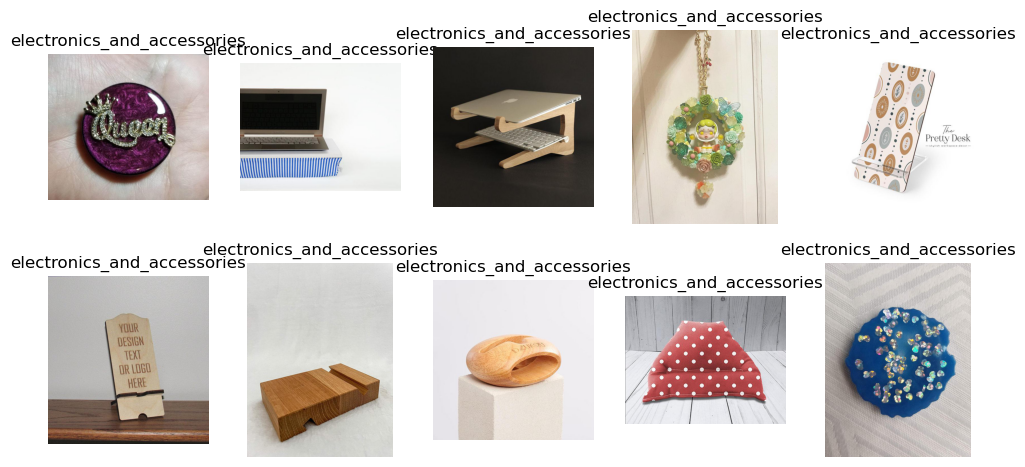

In [13]:
show(images, titles)

## Model Training for Parquet data

In [14]:
 # Loading "stopwords" and "SnowballStemmer" based on German language to remove morphological affixes from German words
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
 #Function to perform cleaning of textual data
def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    text = text.lower()
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

In [21]:
df_train['combined_data'] = [str(df_train['title'][i]) + " " 
                                + str(df_train['description'][i]) + " " 
                                + str(df_train['tags'][i]) + " " 
                                + str(df_train['room'][i]) + " "
                                + str(df_train['craft_type'][i]) + " "
                                + str(df_train['recipient'][i]) + " "
                                + str(df_train['material'][i]) + " "
                                + str(df_train['occasion'][i]) + " "
                                + str(df_train['holiday'][i]) + " "
                                + str(df_train['art_subject'][i]) + " "
                                + str(df_train['style'][i]) + " "
                                + str(df_train['shape'][i]) + " "
                                + str(df_train['pattern'][i])   
                                for i in range(len(df_train))]

In [22]:
df_train["comment_clean"] = df_train["combined_data"].map(lambda x: clean_text(x, for_embedding=True) if isinstance(x, str) else x)

In [23]:
df_train['comment_clean']

0         full face custom motorcycle helmet , motorcycl...
1         full face predator motorcycle helmet , custom ...
2         full face custom motorcycle helmet , motorcycl...
3         full face custom motorcycle helmet , motorcycl...
4         full face predator motorcycle helmet , custom ...
                                ...                        
245480    vintage apri nights black alumesh evening bag ...
245481    gold eloquent envelope clutch bag looking for ...
245482    personalized pouch , toiletry bag , makeup bag...
245483    floral handbag , canvas bag , bridesmaid bag ,...
245484    modern marrakesh bohemian seed beaded clutch b...
Name: comment_clean, Length: 245485, dtype: object

In [24]:
# Separate target and feature variables
y_top = df_train['top_category_id']
y_bottom = df_train['bottom_category_id']
y_color = df_train['color_id']

In [25]:
train, test = train_test_split(df_train, test_size=0.2, random_state=42)

In [26]:
# create an instance of the CountVectorizer with desired options
vectorizer = CountVectorizer(stop_words='english')

# fit the vectorizer on the text data to learn the vocabulary
vectorizer.fit(train['comment_clean'])
vectorizer.fit(test['comment_clean'])

# transform the text data to a matrix of token counts
train_X_vector = vectorizer.transform(train['comment_clean'])
test_X_vector = vectorizer.transform(test['comment_clean'])

In [27]:
# Use the best hyperparameters to train the RFC model and predict the top category on the test data
rfc_top = RandomForestClassifier(n_estimators=50, min_samples_split=2, min_samples_leaf=1, random_state=42)
rfc_top.fit(train_X_vector, train['top_category_id'])
y_top_pred = rfc_top.predict(test_X_vector)

# Evaluate model
train_acc = rfc_top.score(train_X_vector, train['top_category_id'])
test_acc = rfc_top.score(test_X_vector, test['top_category_id'])
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

print(classification_report(test['top_category_id'], y_top_pred))

Train accuracy: 0.9981
Test accuracy: 0.8207
              precision    recall  f1-score   support

           0       0.87      0.62      0.72      2488
           1       0.89      0.38      0.53      1758
           2       0.84      0.73      0.78      1399
           3       0.91      0.76      0.83      2401
           4       0.89      0.77      0.82      1465
           5       0.82      0.98      0.89      6365
           6       0.84      0.88      0.86      8408
           7       0.94      0.76      0.84      1665
           8       0.73      0.93      0.82     10734
           9       0.84      0.86      0.85      1881
          10       0.81      0.75      0.78      2179
          11       0.94      0.77      0.84      1306
          12       0.94      0.94      0.94      2082
          13       0.89      0.67      0.77      2882
          14       0.85      0.52      0.64      2084

    accuracy                           0.82     49097
   macro avg       0.87      0.75  

In [28]:
# Use the best hyperparameters to train the RFC model and predict the top category on the test data
rfc_bottom = RandomForestClassifier(n_estimators=50, max_depth=5, min_samples_split=5, random_state=42)
rfc_bottom.fit(train_X_vector, train['bottom_category_id'])
y_bottom_pred = rfc_bottom.predict(test_X_vector)

# Evaluate model
train_acc = rfc_bottom.score(train_X_vector, train['bottom_category_id'])
test_acc = rfc_bottom.score(test_X_vector, test['bottom_category_id'])
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

print(classification_report(test['bottom_category_id'], y_bottom_pred))

Train accuracy: 0.0528
Test accuracy: 0.0450


C:\Users\chris\anaconda3\envs\snowflakes\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        22
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        13
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00        24
          10       0.00      0.00      0.00        25
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00        17
          13       0.00      0.00      0.00        15
          14       0.00      0.00      0.00        15
          15       0.00      0.00      0.00        14
          16       0.00      0.00      0.00        17
          17       0.00      0.00      0.00        15
          18       0.00    

C:\Users\chris\anaconda3\envs\snowflakes\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chris\anaconda3\envs\snowflakes\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# Use the best hyperparameters to train the RFC model and predict the top category on the test data
rfc_color = RandomForestClassifier(n_estimators=50, max_depth=5, min_samples_split=5, random_state=42)
rfc_color.fit(train_X_vector, train['color_id'])
y_color_pred = rfc_color.predict(test_X_vector)

# Evaluate model
train_acc = rfc_color.score(train_X_vector, train['color_id'])
test_acc = rfc_color.score(test_X_vector, test['color_id'])
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

print(classification_report(test['color_id'], y_color_pred))

Train accuracy: 0.1711
Test accuracy: 0.1686
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2529
           1       0.15      0.95      0.26      6512
           2       0.74      0.04      0.08      5532
           3       0.00      0.00      0.00       559
           4       0.88      0.01      0.02      4531
           5       1.00      0.01      0.02      1261
           6       0.00      0.00      0.00       431
           7       1.00      0.00      0.00      2175
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00      3131
          10       0.00      0.00      0.00      1096
          11       0.00      0.00      0.00      3115
          12       0.00      0.00      0.00      1290
          13       0.00      0.00      0.00      1018
          14       0.00      0.00      0.00      3027
          15       0.00      0.00      0.00       223
          16       0.88      0.01   

C:\Users\chris\anaconda3\envs\snowflakes\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chris\anaconda3\envs\snowflakes\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chris\anaconda3\envs\snowflakes\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Submission for prediction

In [30]:
# Create a dataframe with the predicted categories and colors
df_predictions = pd.DataFrame({
    'product_id': test['product_id'],
    'top_category_id': y_top_pred,
    'bottom_category_id': y_bottom_pred,
    'color_id': y_color_pred
})

# Save dataframe to a file
student_id = "22267441"
df_predictions.to_parquet(f"predictions_{student_id}.parquet", index=False)

In [39]:
# set the path to your data directory
pdf = 'C:/Users/chris/CA684_ML_Assignment/predictions_22267441.parquet'

# read the Parquet file into a Pandas DataFrame
df_predictions = pd.read_parquet(pdf)

# print the DataFrame
print(df_predictions)


       product_id  top_category_id  bottom_category_id  color_id
0       575358298                6                 866         1
1      1081420432                5                 866        17
2      1354432559                8                 866         1
3       909070658                5                 866        17
4      1230254536                4                 866         1
...           ...              ...                 ...       ...
49092  1098228551                8                 866        17
49093   907006335                8                 866         1
49094  1308270231               12                 866         1
49095   884846385                3                 261        17
49096   815234074                8                 866        17

[49097 rows x 4 columns]
